In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

## Check the dataset size

In [33]:
dataset_prefix = "audio_60k"
speech_prefix = os.path.join(dataset_prefix, "train/speech")
noise_prefix = os.path.join(dataset_prefix, "train/noise")
music_prefix = os.path.join(dataset_prefix, "train/music")

test_prefix = os.path.join(dataset_prefix, "test")

In [34]:
speeh_files = os.listdir(speech_prefix)
noise_files = os.listdir(noise_prefix)
music_files = os.listdir(music_prefix)

test_files = os.listdir(test_prefix)

In [35]:
print("speech: {} files".format(len(speeh_files)))
print("noise: {} files".format(len(noise_files)))
print("music: {} files".format(len(music_files)))
print("---")
print("test: {} files".format(len(test_files)))

speech: 15041 files
noise: 15107 files
music: 14852 files
---
test: 15000 files


## Import some tools for audios processing

In [36]:
import librosa
import librosa.display
from scipy.io.wavfile import read as read_wav
from IPython.display import HTML, Audio, display_html

Pick some random music or choose the song you like:

In [41]:
# sample_music_file = os.path.join(music_prefix, np.random.choice(music_files, 1)[0])

sample_music_file = "audio_60k/train/music/64769341495.wav" # Staying Alive by Bee Gees

All audiofiles in the dataset have soundrate 16k and 3 seconds duration:

In [42]:
from sklearn.preprocessing import minmax_scale

In [43]:
def read_audio(path, sr=None):
    wav, sr = librosa.load(path, sr=None)
    assert sr == 16000
    return wav

def audio_player(audio_path):
    return f'<audio preload="none" controls="controls"><source src="{audio_path}" type="audio/wav"></audio>'


def display_manifest(df):
    display_df = df
    display_df['wav'] = [audio_player(path) for path in display_df.wav_path]
    audio_style = '<style>audio {height:44px;border:0;padding:0 20px 0px;margin:-10px -20px -20px;}</style>'
    display_df = display_df[['wav', 'label']]
    display(HTML(audio_style + display_df.to_html(escape=False)))
    del display_df
    gc.collect()

Output a small audiplayer:

In [45]:
music_wav = read_audio(sample_music_file, sr=None)
Audio(music_wav, rate=16000, autoplay=False)

In [46]:
music_wav.shape

(48000,)

Let's plot the frequencies:

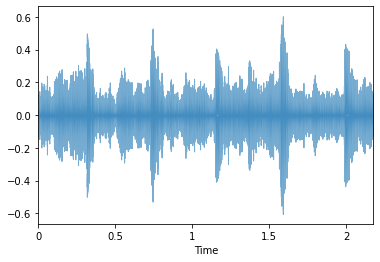

In [47]:
librosa.display.waveplot(music_wav, alpha=0.6)
plt.show()

## Read all the files:

We will store them in one table with 48k fearures

In [48]:
from tqdm.notebook import tqdm as tqdm

In [49]:
train_paths = \
    [speech_prefix + "/" + x for x in speeh_files] + \
    [noise_prefix + "/" + x for x in noise_files] + \
    [music_prefix + "/" + x for x in music_files]

train_labels = \
    [0] * len(speeh_files) + \
    [1] * len(noise_files) + \
    [2] * len(music_files)

test_paths = [test_prefix + "/" + x for x in test_files]

In [50]:
X_train_raw = []
y_train = []

for filename, label in tqdm(zip(train_paths, train_labels)):
    X_train_raw.append(read_audio(filename, sr=None))
    y_train.append(label)
    
X_train_raw = np.array(X_train_raw)
y_train = np.array(y_train)

In [51]:
X_test_raw = []

for filename in tqdm(test_paths):
    X_test_raw.append(read_audio(filename, sr=None))
    
X_test_raw = np.array(X_test_raw)

In [52]:
X_train_raw.shape, X_test_raw.shape

((45000, 48000), (15000, 48000))

In [53]:
X_train_db = pd.DataFrame(data=X_train_raw, columns=[str(x) for x in np.arange(48000)])
X_train_db["filename"] = [x.split("/")[-1] for x in train_paths]
X_train_db["label"] = train_labels

In [54]:
X_test_db = pd.DataFrame(data=X_test_raw, columns=[str(x) for x in np.arange(48000)])
X_test_db["filename"] = [x.split("/")[-1] for x in test_paths]

## Basic audio feature extraction:

We will calculate some series that describe the audio:
- [spectral centroid](https://en.wikipedia.org/wiki/Spectral_centroid)
- [spectral rolloff](https://librosa.org/doc/0.7.1/generated/librosa.feature.spectral_rolloff.html)
- [zero crossings](https://librosa.org/doc/0.7.1/generated/librosa.core.zero_crossings.html#librosa.core.zero_crossings)

Example on "Staying Alive"

In [55]:
sr = 16000

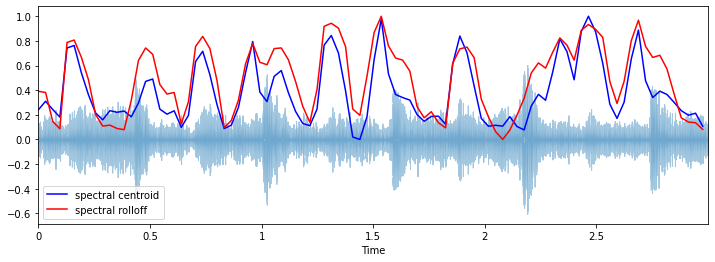

In [56]:
spectral_centroids = librosa.feature.spectral_centroid(music_wav, sr=sr)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(music_wav, sr=sr)[0]

plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=sr)

librosa.display.waveplot(music_wav, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_centroids), color='b', label="spectral centroid")
plt.plot(t, minmax_scale(spectral_rolloff), color='r', label="spectral rolloff")
plt.legend(loc="lower left")
plt.show()

Display zero crossings:

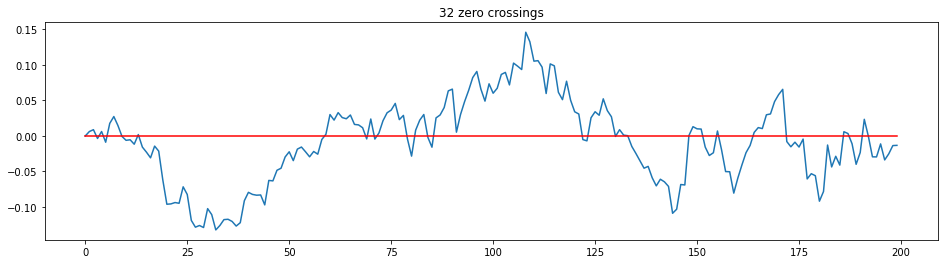

In [57]:
intro = music_wav[:200]

plt.figure(figsize=(16, 4))
plt.plot(intro)
plt.plot(np.zeros_like(intro), c="r")
plt.title("{} zero crossings".format(sum(librosa.zero_crossings(intro, pad=False))))
plt.show()

Now we will design a basic feature extractor:
- apply three calculate spectral centroid, spectral rolloff, zero_corssings (use lower SR)
- apply aggregation function to the original data and three series above
- concatenate the result into resulting feature-vector

In [58]:
def simple_aggregate(x):
    return  np.mean(x)

def basic_feature_extractor(wav, aggr_function, sr=16000):
    sp_cent = librosa.feature.spectral_centroid(wav, sr=sr)[0]
    sp_rolloff = librosa.feature.spectral_rolloff(wav, sr=sr)[0]
    zero_crossings = librosa.zero_crossings(wav, pad=False)
    chunks = [wav, sp_cent, sp_rolloff, zero_crossings]
     
    return np.array(list(map(aggr_function, chunks))).reshape(-1) 

In [59]:
basic_feature_extractor(music_wav, simple_aggregate).shape

(4,)

## Extract all the features

In [60]:
from time import time

In [61]:
SR = 1000

In [62]:
start = time()
X_train = np.apply_along_axis(lambda x: basic_feature_extractor(x, simple_aggregate, SR), 1, X_train_raw)
middle = time()
print("Train extract done: {:.2f}s".format(middle - start))
X_test = np.apply_along_axis(lambda x: basic_feature_extractor(x, simple_aggregate, SR), 1, X_test_raw)
end = time()
print("Test extract done: {:.2f}s".format(end - middle))

Train extract done: 307.79s
Test extract done: 101.80s


In [63]:
X_train.shape, X_test.shape

((45000, 4), (15000, 4))

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [65]:
clf = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
np.mean(cross_val_score(clf, X_train, y_train, cv=3))

0.6553333333333334

In [66]:
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)

In [67]:
data = np.array([test_files, test_preds]).T
submission_file = pd.DataFrame(data=data, columns=["filename", "class"])
submission_file.to_csv("sample_submission.csv",index=None)